<a href="https://colab.research.google.com/github/saatvik1879/mltask/blob/main/MLtask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## reading data and visualisation

In [2]:
df = pd.get_dummies(pd.read_csv("/content/lungcapacity.csv"))
#had to remove row 202 as it had age = 999
df = df.drop([202])

df = df.dropna()
X = df.to_numpy().astype('float32')[:,1:]
y = df.to_numpy().astype('float32')[:,0]
df

,LungCap(cc),Age( years),Height(inches),No of children,Weight (kg),Smoke_9,Smoke_no,Smoke_yes,Gender_female,Gender_male,Caesarean_999,Caesarean_no,Caesarean_yes
0,6.475,6.0,62.1,3,85.70,False,False,False,False,True,False,True,False
1,10.125,18.0,74.7,0,98.75,False,False,True,True,False,False,True,False
2,9.550,16.0,69.7,0,11.01,False,True,False,True,False,False,False,True
3,11.125,14.0,71.0,1,29.78,False,True,False,False,True,False,True,False
4,4.800,5.0,56.9,4,72.84,False,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,9.325,14.0,65.5,0,65.50,False,True,False,False,True,False,True,False
741,9.925,16.0,68.3,3,68.30,False,True,False,True,False,False,True,False
742,8.725,19.0,68.4,3,68.40,False,True,False,True,False,False,True,False
743,7.075,11.0,66.7,4,66.70,False,True,False,False,True,False,False,True


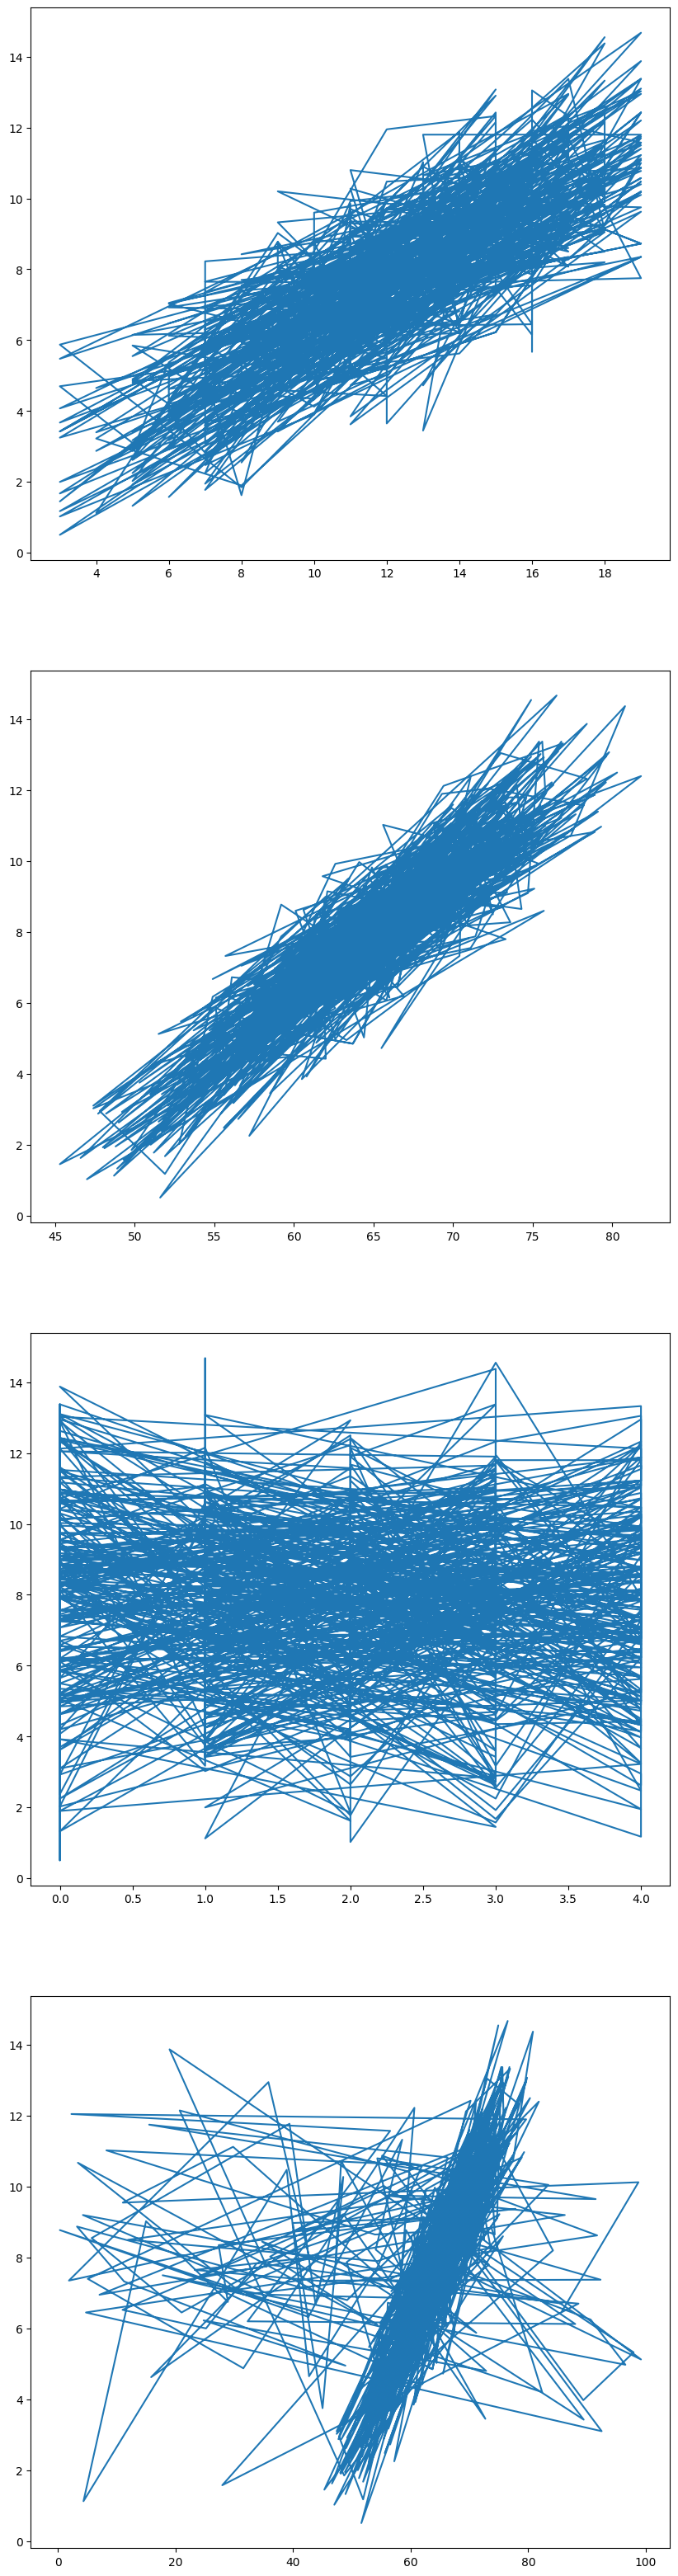

In [3]:

plt.figure(figsize = (10,40))
a=1
for xi in ['Age( years)','Height(inches)','No of children','Weight (kg)']:
  x = df[xi]
  plt.subplot(4,1,a)
  a+=1;
  plt.plot(x,y)
plt.show()

##feature selection
as the features are already of low number I have chosen to skip feature selction

##test train split

In [7]:
a, b, c, d = train_test_split(X, y, test_size=0.25, random_state=42)
X_train = torch.from_numpy(a).to(device)
X_test = torch.from_numpy(b).to(device)
y_train = torch.tensor(c).to(device)
y_test = torch.tensor(d).to(device)
X_train.device


device(type='cuda', index=0)

##model architecture

##1.using pytorch

In [23]:
class Regression(nn.Module):
  def __init__(self,dropout_rate = 0.2):
    super().__init__()
    self.fc1 = nn.Linear(12,16)
    self.bn1 = nn.BatchNorm1d(16)
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(dropout_rate)

    self.fc2 = nn.Linear(16,1)
  def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)  # Apply batch normalization
        out = self.relu1(out)
        out = self.dropout1(out)  # Apply dropout

        out = self.fc2(out)

        return out
model = Regression().to(device)


the cell below needn't be run while testing the model

In [24]:
lossfn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

epochs = 4000
for epoch in range(epochs):
  model.train()
  y_pred = model(X_train)
  loss = lossfn(y_pred,y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model.eval()
  if epoch%400 == 9:
    with torch.inference_mode():
      y_pred2 = model(X_test)
      print(lossfn(y_pred2,y_test))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([538])) that is different to the input size (torch.Size([538, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([180])) that is different to the input size (torch.Size([180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(60.5667, device='cuda:0')
tensor(7.9176, device='cuda:0')
tensor(7.8492, device='cuda:0')
tensor(7.8218, device='cuda:0')
tensor(7.8151, device='cuda:0')
tensor(7.8134, device='cuda:0')
tensor(7.8145, device='cuda:0')
tensor(7.8120, device='cuda:0')
tensor(7.8129, device='cuda:0')
tensor(7.8148, device='cuda:0')


the mean squared error in the case of my pytorch model is 7.8

 saving model and using it from saved state

In [26]:

torch.save(model.state_dict(),'/content/modelparams.pt')

upload the file with model parameters and run the below cell and the one where 'regressor class' is defined to acess the model

In [27]:
new_model  = Regression()
new_model.load_state_dict(torch.load('/content/modelparams.pt'))

<All keys matched successfully>

## 2.using random forests

a - X_train

b - X_test

c - y_train

d - y_test

In [19]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
regressor.fit(a, c)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=10, oob_score=True, random_state=0)

In [20]:
from sklearn.metrics import mean_squared_error
predictions = regressor.predict(b)
mse = mean_squared_error(d,predictions)
print(mse)

1.285684346980809


the mean squared error in the case of random forests is 1.28